<a href="https://colab.research.google.com/github/bahram3000/IBM_Jupyter_exam/blob/main/Gold_models_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
from my_func_pkg import exp_change
from my_func_pkg import most_frequency_cenarios
from my_func_pkg import build_data_for_auto_NN
from my_func_pkg import Forie

In [2]:
gold_df=yf.download(tickers='GC=F',interval='1d',period='max')

/tmp/ipython-input-1489891016.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_df=yf.download(tickers='GC=F',interval='1d',period='max')
[*********************100%***********************]  1 of 1 completed


In [3]:
closes=gold_df.loc[:,"Close"].values[:,0]

In [4]:
ret=exp_change(closes)

In [60]:
mfc=most_frequency_cenarios(closes,10,ngreater=0.9,ncenarios=200,lcenarios=30)

100%|██████████| 200/200 [01:14<00:00,  2.67it/s]


In [11]:
preve_len=372

In [20]:
x,y=build_data_for_auto_NN(ret,preve_len,30)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

In [22]:
model = models.Sequential([
    layers.LSTM(500,input_shape=(preve_len,1)),
    layers.Dense(100),
    layers.Dense(30)  # خروجی با همان ابعاد ورودی
])

In [25]:
model.compile(
    optimizer='adam',
    loss='mse'
)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [29]:
n_batch=20
epc=n_batch+1
batchsz=x.shape[0]//20

In [30]:
model.fit(x_train, y_train, epochs=epc, batch_size=batchsz)

Epoch 1/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - loss: 0.5930
Epoch 2/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - loss: 0.0273
Epoch 3/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - loss: 0.0040
Epoch 4/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 7.0392e-04
Epoch 5/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - loss: 2.1210e-04
Epoch 6/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - loss: 1.3956e-04
Epoch 7/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - loss: 1.2583e-04
Epoch 8/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - loss: 1.2261e-04
Epoch 9/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - loss: 1.2296e-04
Epoch 10/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 1.2503e-04
Epoch 11/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - loss: 1.2509e-04
Epoch 12/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - loss: 1.2428e-04
Epoch 13/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - loss: 1.2421e-04
Epoch 14/21
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 1.2291e-04
Epoch 15/21
1

In [31]:
model.save("/content/sample_data/Medium_NN.keras")

In [33]:
nn_predict=model.predict(x)

184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


In [39]:
nn_ret_predict=nn_predict[-1]

In [35]:
forie_model=Forie(ret)

In [37]:
with open("/content/Foureih_params_2m.c5",'rb') as f:
  forie_model.all_constant_params=pickle.load(f)

In [40]:
forieh_ret_predict=forie_model.predict(np.arange(len(x),len(x)+30))

In [41]:
def base_cenarios_by_given_future_dt(future_dt:np.ndarray,l_cenarios:int,base_dt:np.ndarray):
  b_cenarios=np.zeros((l_cenarios,))
  for j in range(l_cenarios):
      if j==0:
        b_cenarios[j]=base_dt[-1]*future_dt[0]
      else:
        b_cenarios[j]=b_cenarios[j-1]*future_dt[j]
  return b_cenarios

In [50]:
base_nn=base_cenarios_by_given_future_dt(nn_ret_predict,l_cenarios=30,base_dt=closes)

In [51]:
base_forieh=base_cenarios_by_given_future_dt(forieh_ret_predict,l_cenarios=30,base_dt=closes)

In [61]:
mfc

array([3372.28267957, 3491.5617179 , 3610.84075624, 3730.11979457,
       3849.3988329 ])

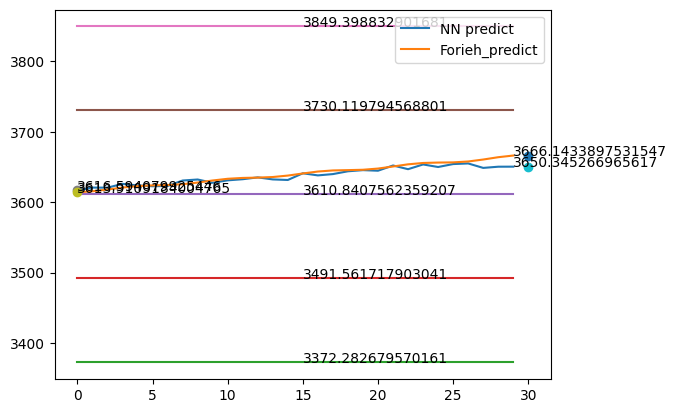

In [65]:
plt.plot(base_nn)
plt.plot(base_forieh)
plt.plot([mfc[0]]*30)
plt.plot([mfc[1]]*30)
plt.plot([mfc[2]]*30)
plt.plot([mfc[3]]*30)
plt.plot([mfc[4]]*30)
plt.text(x=15,y=mfc[0],s=f'{mfc[0]}')
plt.text(x=15,y=mfc[1],s=f'{mfc[1]}')
plt.text(x=15,y=mfc[2],s=f'{mfc[2]}')
plt.text(x=15,y=mfc[3],s=f'{mfc[3]}')
plt.text(x=15,y=mfc[4],s=f'{mfc[4]}')
plt.legend(['NN predict','Forieh_predict'])
plt.plot([0],[base_nn[0]],'o')
plt.text(x=0,y=base_nn[0],s=f'{base_nn[0]}')
plt.plot([0],[base_forieh[0]],'o')
plt.text(x=0,y=bace_forieh[0],s=f'{base_forieh[0]}')
plt.plot([30],[base_nn[-1]],'o')
plt.text(x=29,y=base_nn[-1],s=f'{base_nn[-1]}')
plt.plot([30],[base_forieh[-1]],'o')
plt.text(x=29,y=bace_forieh[-1],s=f'{base_forieh[-1]}')

plt.show()

In [56]:
bace_nn

array([3616.59407993, 3620.62904067, 3620.51552655, 3625.90749391,
       3623.67345187, 3622.52677281, 3622.94004258, 3630.65313231,
       3632.09611278, 3627.45067469, 3630.92218915, 3632.51071068,
       3635.11538025, 3632.21503883, 3631.42612417, 3640.94472339,
       3637.94077108, 3639.79387006, 3643.78095181, 3645.40333324,
       3644.57548512, 3652.01356451, 3646.74839393, 3653.4857819 ,
       3649.84519128, 3654.03124462, 3654.89633524, 3648.57196679,
       3650.27042183, 3650.34526697])

In [57]:
bace_forieh

array([3613.9109184 , 3615.39027214, 3617.87466075, 3620.66329411,
       3622.74556833, 3623.7422945 , 3624.28440111, 3625.45152148,
       3627.77079065, 3630.70488137, 3633.1228939 , 3634.34350306,
       3634.78962901, 3635.62456789, 3637.68171119, 3640.67437887,
       3643.43189499, 3644.97004947, 3645.41971605, 3645.93609961,
       3647.64404489, 3650.58508502, 3653.64984458, 3655.5832912 ,
       3656.15532712, 3656.40427952, 3657.69764   , 3660.46254875,
       3663.76426463, 3666.14338975])

In [64]:
mfc

array([3372.28267957, 3491.5617179 , 3610.84075624, 3730.11979457,
       3849.3988329 ])

In [58]:
closes[-1]

np.float64(3613.199951171875)